In [0]:
import numpy as np
from skimage import io, color
from skimage.transform import resize
from keras.applications.inception_resnet_v2 import preprocess_input, InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, RepeatVector, Reshape, concatenate, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint 
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave,imshow
import PIL
import os
from PIL import Image
import tensorflow as tf
from skimage.io import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
batch_size = 8
train_images_path = './data/images/'
test_images_path = './data/test/'
colorizer_input = (256, 256)
inception_input_size = (299, 299)
epochs = 50
steps_per_epoch = 50

In [0]:
#Load weights
inception_model = InceptionResNetV2(weights='imagenet', include_top=True)

In [0]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [0]:
embed_input = Input(shape=(1000,))

# encoder
encoder_input = Input(shape=(256, 256, 1))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# fusion between our model and inception
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

# decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1072 (Conv2D)            (None, 128, 128, 64) 640         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_1073 (Conv2D)            (None, 128, 128, 128 73856       conv2d_1072[0][0]                
__________________________________________________________________________________________________
conv2d_1074 (Conv2D)            (None, 64, 64, 128)  147584      conv2d_1073[0][0]                
____________________________________________________________________________________________

In [0]:
#Create embedding
def create_resnet_embedding(grayscaled_rgb):
    resized_grayscaled_rgb = []
    for i in grayscaled_rgb:
        if i.shape[0] != 299 and i.shape[1] != 299:
            resized_grayscaled_rgb.append(resize(i, (299, 299, 3), mode='constant'))
        else:
            resized_grayscaled_rgb.append(i)
    resized_grayscaled_rgb = np.array(resized_grayscaled_rgb)
    resized_grayscaled_rgb = preprocess_input(resized_grayscaled_rgb)
    
    return inception_model.predict(resized_grayscaled_rgb)

In [0]:
def image_gen_train():
    test = True
    for batch in datagen.flow_from_directory(
        train_images_path,
        target_size=inception_input_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=None):
        
        # scale batch 
        batch = 1.0/255*batch

        # get image grayscale with 3 channels
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        
        batch_lab = []
        for img in batch:
            batch_lab.append(resize(img, (256, 256, 3), mode='constant'))
        batch_lab = np.array(batch_lab)
        batch_lab = rgb2lab(batch_lab)
        
        # b/w channel
        batch_l = batch_lab[:,:,:,0]
        batch_l = batch_l.reshape(batch_l.shape+(1,))
        
        batch_ab = batch_lab[:,:,:,1:] / 128
        yield ([batch_l, create_resnet_embedding(grayscaled_rgb)], batch_ab)

In [0]:
checkpoint_path = "output/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# tensorboard = TensorBoard(log_dir="/output")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_gen_train(), 
                    epochs=epochs, 
                    callbacks=[cp_callback], 
                    steps_per_epoch=steps_per_epoch, 
                    workers=0)

Epoch 1/50
Found 12 images belonging to 2 classes.
50/50 [==============================] - 37s 747ms/step - loss: 0.0204

Epoch 00001: saving model to output/cp.ckpt
Epoch 2/50
50/50 [==============================] - 30s 601ms/step - loss: 0.0034

Epoch 00002: saving model to output/cp.ckpt
Epoch 3/50
50/50 [==============================] - 30s 600ms/step - loss: 0.0033

Epoch 00003: saving model to output/cp.ckpt
Epoch 4/50
50/50 [==============================] - 30s 602ms/step - loss: 0.0033

Epoch 00004: saving model to output/cp.ckpt
Epoch 5/50
50/50 [==============================] - 30s 598ms/step - loss: 0.0032

Epoch 00005: saving model to output/cp.ckpt
Epoch 6/50
50/50 [==============================] - 30s 601ms/step - loss: 0.0032

Epoch 00006: saving model to output/cp.ckpt
Epoch 7/50
50/50 [==============================] - 30s 600ms/step - loss: 0.0032

Epoch 00007: saving model to output/cp.ckpt
Epoch 8/50
50/50 [==============================] - 30s 600ms/step - lo

In [0]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("color_tensorflow_real_mode_v2.h5")

In [0]:
imgs = []
inception_imgs = []
colorization_imgs = []
for f in os.listdir(test_images_path):
    img = load_img(os.path.join(test_images_path,f))
    imgs.append(img_to_array(img))
imgs = np.asarray(imgs)
imgs = 1.0/255*imgs
for img in imgs:
    inception_imgs.append(resize(img, (299, 299, 3), mode='constant'))
    colorization_imgs.append(resize(img, (256, 256, 3), mode='constant'))

inception_imgs = np.array(inception_imgs)
inception_imgs = gray2rgb(rgb2gray(inception_imgs))
embed = create_resnet_embedding(inception_imgs)

colorization_imgs = np.array(colorization_imgs)
X_batch = rgb2lab(colorization_imgs)[:,:,:,0] 
X_batch = X_batch.reshape(X_batch.shape+(1,))

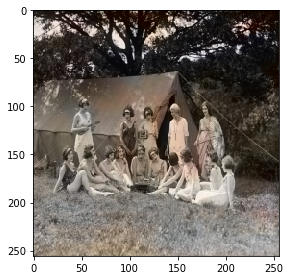

In [0]:
from skimage import img_as_ubyte

output = model.predict([X_batch, embed])
output = output * 128



idx = 0
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = X_batch[i,:,:,0] 
    cur[:,:,1:] = output[i]
    if i == idx:
        imshow(lab2rgb(cur))
    imsave("output/" + str(epochs) + "img_" + str(i) + '_' + str(steps_per_epoch) + ".png", lab2rgb(cur))